In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import sqlite3
import json

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.9.1


## read in data from local json database
read in data 

In [4]:
df = pd.read_json('../ML_data.json')

## clean data

In [5]:
from datetime import datetime
dataset = df[['STN','ST','DATETIME','H','Temp','P','Vm','Vmsat']]

df_index = (dataset['DATETIME']>datetime(2015,1,1,0)) & (dataset['DATETIME']<datetime(2020,1,1,0))
dataset = dataset[df_index]

#stnlist=['新竹浮標','龜山島浮標','臺東外洋浮標','龍洞浮標','小琉球浮標','花蓮浮標','東沙島浮標','馬祖浮標']
#stnlist=['東沙島浮標']
#stnlist=['新竹浮標','臺東外洋浮標','東沙島浮標','馬祖浮標']
stnlist=['臺東外洋浮標','東沙島浮標','馬祖浮標']

dataset = dataset[dataset['STN'].isin(stnlist)]
dataset = dataset.dropna()

In [6]:
dataset.isna().sum()

STN         0
ST          0
DATETIME    0
H           0
Temp        0
P           0
Vm          0
Vmsat       0
dtype: int64

Drop those rows to keep this initial tutorial simple.

In [7]:
dataset = dataset.dropna()
dataset.tail()

,STN,ST,DATETIME,H,Temp,P,Vm,Vmsat
877101,馬祖浮標,C6W08,2018-12-30 20:00:00,3.52,16.3,1030.6,14.0,16.348304
877107,馬祖浮標,C6W08,2018-12-31 02:00:00,2.73,16.1,1030.4,12.4,14.287296
877113,馬祖浮標,C6W08,2018-12-31 08:00:00,3.51,16.1,1032.7,12.9,14.614159
877119,馬祖浮標,C6W08,2018-12-31 14:00:00,3.10,15.5,1029.3,12.5,14.517667
877125,馬祖浮標,C6W08,2018-12-31 20:00:00,3.33,15.8,1031.2,12.9,13.381326


/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: Glyph 33274 (\N{CJK UNIFIED IDEOGRAPH-81FA}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: Glyph 26481 (\N{CJK UNIFIED IDEOGRAPH-6771}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: Glyph 27915 (\N{CJK UNIFIED IDEOGRAPH-6D0B}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: Glyph 28014 (\N{CJK UNIFIED IDEOGRAPH-6D6E}) mi

<Figure size 3200x1600 with 0 Axes>

/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33274 (\N{CJK UNIFIED IDEOGRAPH-81FA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26481 (\N{CJK UNIFIED IDEOGRAPH-6771}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27915 (\N{CJK UNIFIED IDEOGRAPH-6D0B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28014 (\N{CJK

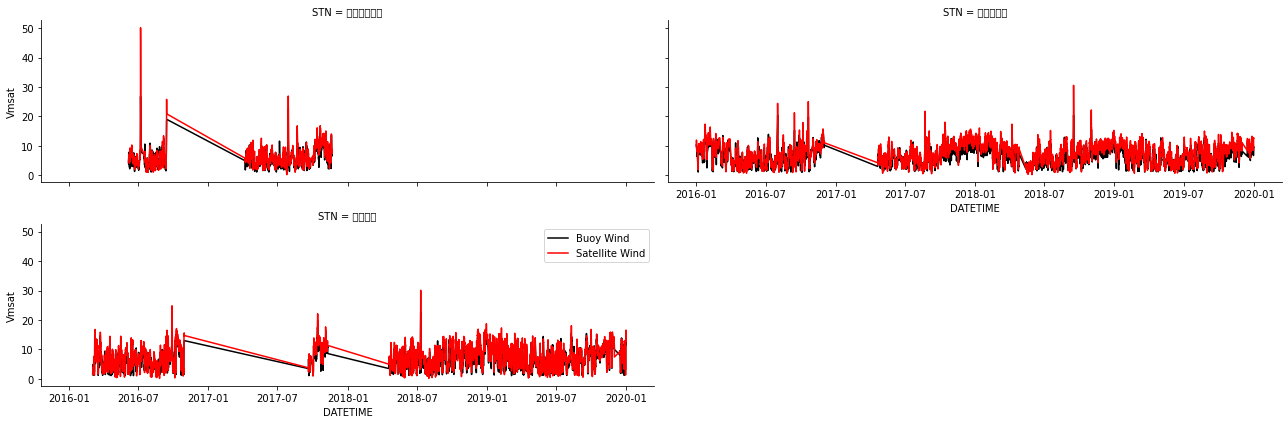

In [68]:
%matplotlib inline
plt.figure(figsize=(16,8),dpi=200)
g = sns.FacetGrid(dataset, col="STN", col_wrap=2, height=3, aspect=3)
g.map(sns.lineplot, 'DATETIME','Vm',color='k')
g.map(sns.lineplot, 'DATETIME','Vmsat',color='r')
plt.legend(labels=['Buoy Wind','Satellite Wind'])

In [69]:
dataset.pop('DATETIME')
dataset.pop('ST')
dataset.pop('STN')

149823    臺東外洋浮標
149829    臺東外洋浮標
149835    臺東外洋浮標
149841    臺東外洋浮標
149847    臺東外洋浮標
           ...  
877101      馬祖浮標
877107      馬祖浮標
877113      馬祖浮標
877119      馬祖浮標
877125      馬祖浮標
Name: STN, Length: 9078, dtype: object

### Split the data into train and test

Now split the dataset into a training set and a test set.

Use the test set in the final evaluation of your models.

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

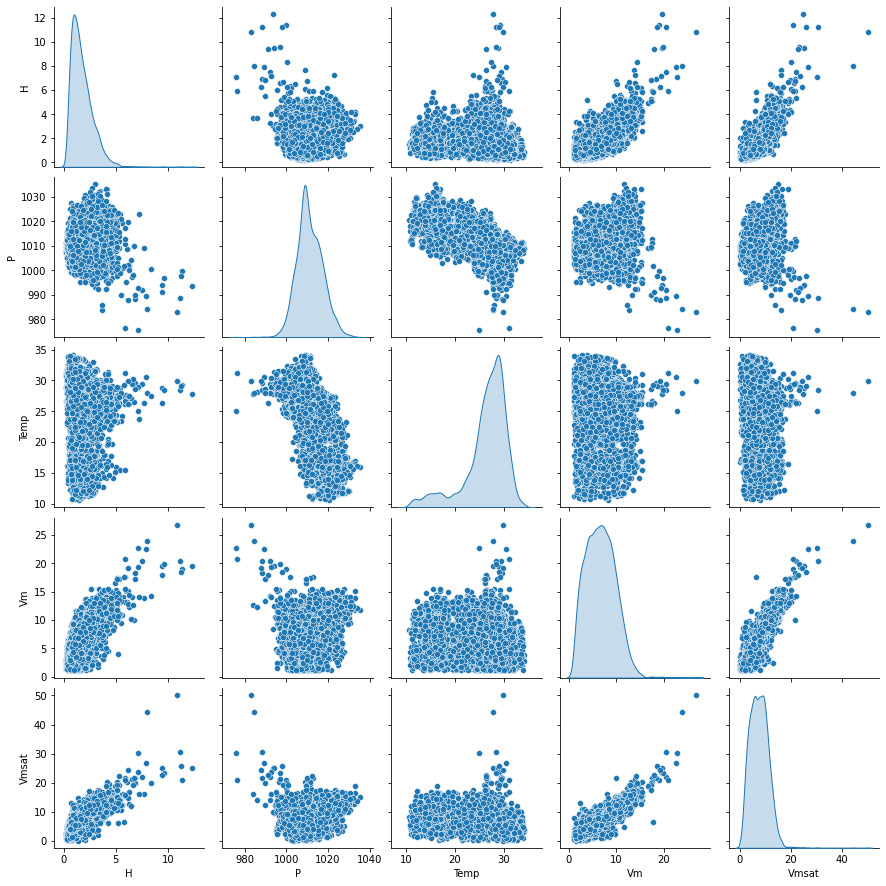

In [9]:
sns.pairplot(train_dataset[['H', 'P', 'Temp', 'Vm','Vmsat']], diag_kind='kde')

Also look at the overall statistics, note how each feature covers a very different range:

In [10]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
H,7262.0,1.747535,1.047002,0.240000,0.970000,1.510000,2.280000,12.300000
Temp,7262.0,26.327279,4.359655,10.600000,25.000000,27.300000,29.200000,34.200000
P,7262.0,1011.084426,6.154957,975.700000,1007.100000,1010.400000,1015.200000,1035.200000
Vm,7262.0,6.649766,3.067025,1.100000,4.200000,6.500000,8.800000,26.800000
Vmsat,7262.0,7.535785,3.547133,0.143646,4.826973,7.420243,9.935997,50.117094


### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [11]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('H')
test_labels = test_features.pop('H')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [12]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
H,1.747535,1.047002
Temp,26.327279,4.359655
P,1011.084426,6.154957
Vm,6.649766,3.067025
Vmsat,7.535785,3.547133


It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable.

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [13]:
normalizer = preprocessing.Normalization(axis=-1)

Then `.adapt()` it to the data:

In [14]:
normalizer.adapt(np.array(train_features))

2022-06-06 00:38:03.158760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

This calculates the mean and variance, and stores them in the layer. 

In [ ]:
print(normalizer.mean.numpy())

When the layer is called it returns the input data, with each feature independently normalized:

In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

## Linear regression

Before building a DNN model, start with a linear regression.

### One Variable

Start with a single-variable linear regression, to predict `H` from `Vmsat`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

* Normalize the input `Vmsat`.
* Apply a linear transformation ($y = mx+b$) to produce 1 output using `layers.Dense`.

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First create the horsepower `Normalization` layer:

In [22]:
Vmsat = np.array(train_features['Vmsat'])

Vmsat_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
Vmsat_normalizer.adapt(Vmsat)

Build the sequential model:

In [23]:
Vmsat_model = tf.keras.Sequential([
    Vmsat_normalizer,
    layers.Dense(units=1)
])

Vmsat_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `H` from `Vmsat`.

Run the untrained model on the first 10 Vmsat values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [24]:
Vmsat_model.predict(Vmsat[:10])

1/1 [==============================] - 0s 99ms/step


array([[ 0.049],
       [-0.632],
       [ 1.27 ],
       [ 0.3  ],
       [-0.278],
       [ 0.059],
       [-0.658],
       [-1.721],
       [-0.073],
       [ 0.201]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [25]:
Vmsat_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Once the training is configured, use `Model.fit()` to execute the training:

In [26]:
%%time
history = Vmsat_model.fit(
    train_features['Vmsat'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 40.1 s, sys: 5.21 s, total: 45.3 s
Wall time: 33.4 s


Visualize the model's training progress using the stats stored in the `history` object.

In [27]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.463131,0.459231,95
96,0.460508,0.462132,96
97,0.459302,0.465193,97
98,0.462145,0.465989,98
99,0.459100,0.459982,99


In [28]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [H]')
  plt.legend()
  plt.grid(True)

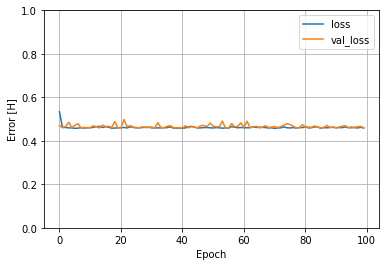

In [29]:
plot_loss(history)

Collect the results on the test set, for later:

In [30]:
test_results = {}

test_results['Vmsat_model'] = Vmsat_model.evaluate(
    test_features['Vmsat'],
    test_labels, verbose=0)

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [31]:
x = tf.linspace(0.0, 20, 251)
y = Vmsat_model.predict(x)

8/8 [==============================] - 0s 2ms/step


In [32]:
def plot_Vmsat(x, y):
  plt.scatter(train_features['Vmsat'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Vmsat')
  plt.ylabel('H')
  plt.legend()

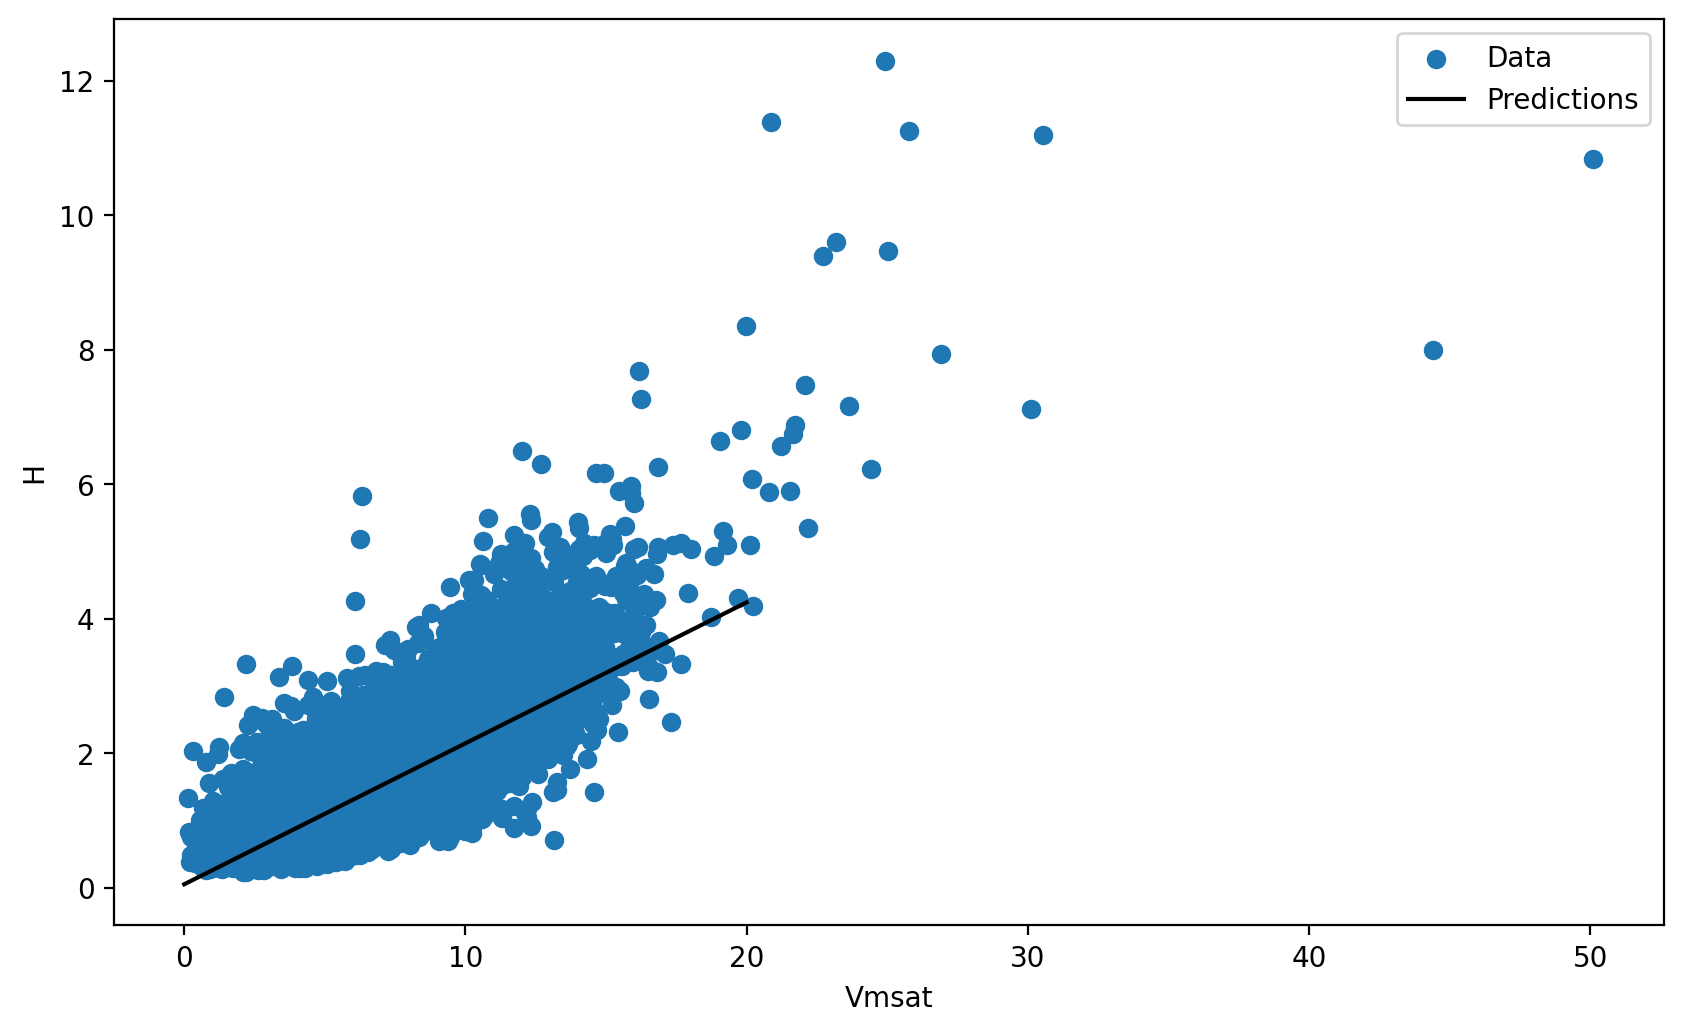

In [33]:
plt.figure(figsize=(10,6),dpi=200)
plot_Vmsat(x,y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [ ]:
linear_model.predict(train_features[:10])

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(4,1)`.

In [ ]:
linear_model.layers[1].kernel

Use the same `compile` and `fit` calls as for the single input `Vmsat` model:

In [37]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [38]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 41.3 s, sys: 5.26 s, total: 46.6 s
Wall time: 34.3 s


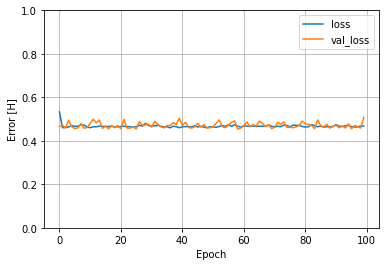

In [39]:
plot_loss(history)

In [40]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [41]:
x = tf.linspace(0.0, 50, 251)
y = linear_model.predict(pd.DataFrame(x))

8/8 [==============================] - 0s 2ms/step


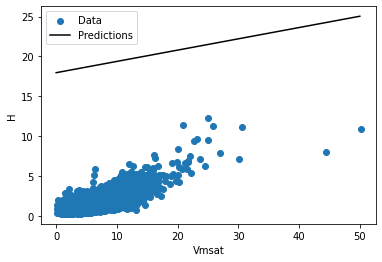

In [42]:
plot_Vmsat(x,y)

In [43]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vmsat_model,0.468918
linear_model,0.518595


## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense( 64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense( 64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### One variable

Start with a DNN model for a single input: "Vmsat"

In [45]:
dnn_Vmsat_model = build_and_compile_model(Vmsat_normalizer)

This model has quite a few more trainable parameters than the linear models.

In [46]:
dnn_Vmsat_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model:

In [47]:
%%time
history = dnn_Vmsat_model.fit(
    train_features['Vmsat'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 51.2 s, sys: 6.93 s, total: 58.2 s
Wall time: 40.5 s


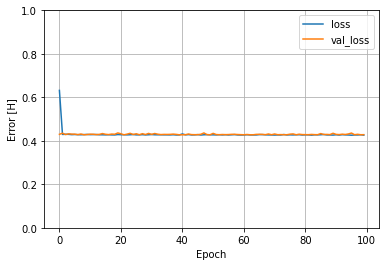

In [48]:
plot_loss(history)

In [49]:
x = tf.linspace(0.0, 20, 251)
y = dnn_Vmsat_model.predict(x)

8/8 [==============================] - 0s 2ms/step


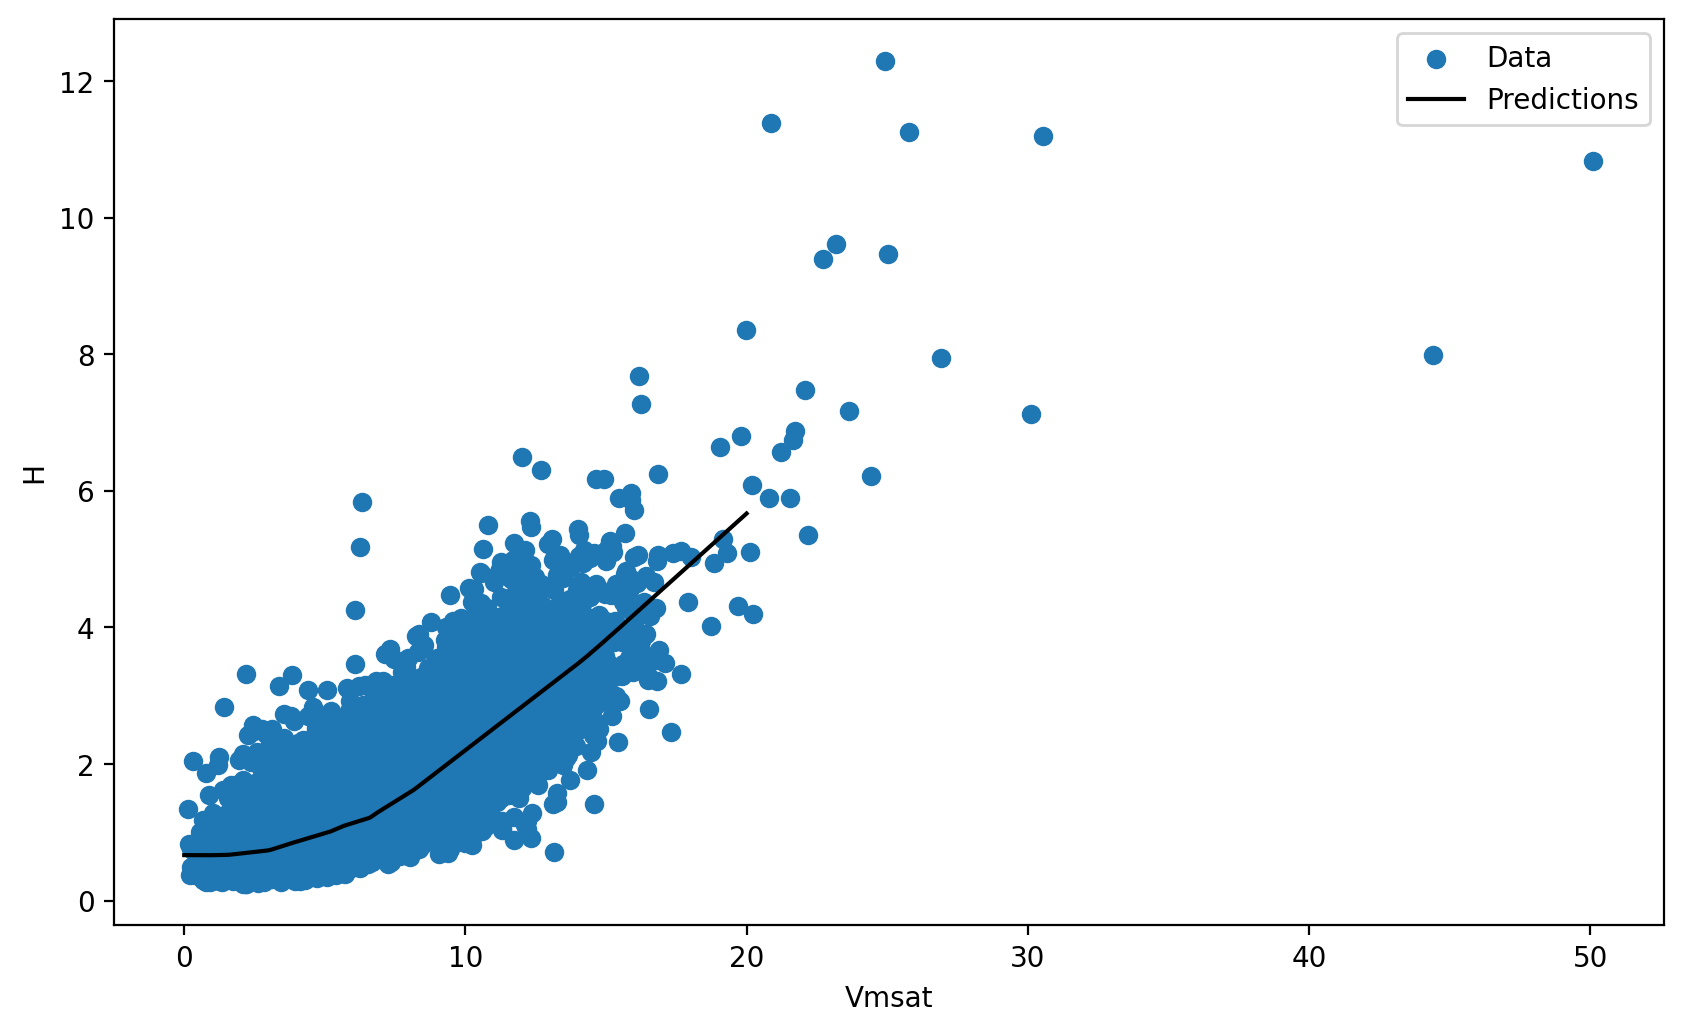

In [50]:
plt.figure(figsize=(10,6),dpi=200)
plot_Vmsat(x,y)

In [51]:
test_results['dnn_Vmsat_model'] = dnn_Vmsat_model.evaluate(
    test_features['Vmsat'], test_labels,
    verbose=0)

In [52]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vmsat_model,0.468918
linear_model,0.518595
dnn_Vmsat_model,0.427581


### Full model

In [53]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                320       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [54]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 49.3 s, sys: 6.84 s, total: 56.2 s
Wall time: 37 s


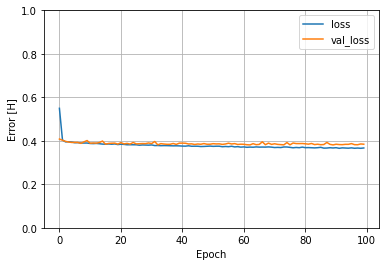

In [55]:
plot_loss(history)

In [56]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=1)

57/57 [==============================] - 0s 2ms/step - loss: 0.3903


In [72]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vmsat_model,0.468918
linear_model,0.518595
dnn_Vmsat_model,0.427581
dnn_model,0.390336


57/57 [==============================] - 0s 2ms/step


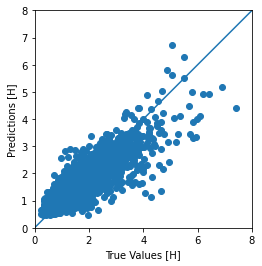

In [73]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

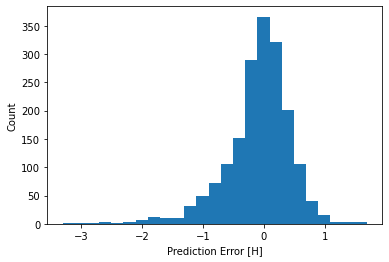

In [74]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
_ = plt.ylabel('Count')

8/8 [==============================] - 0s 2ms/step


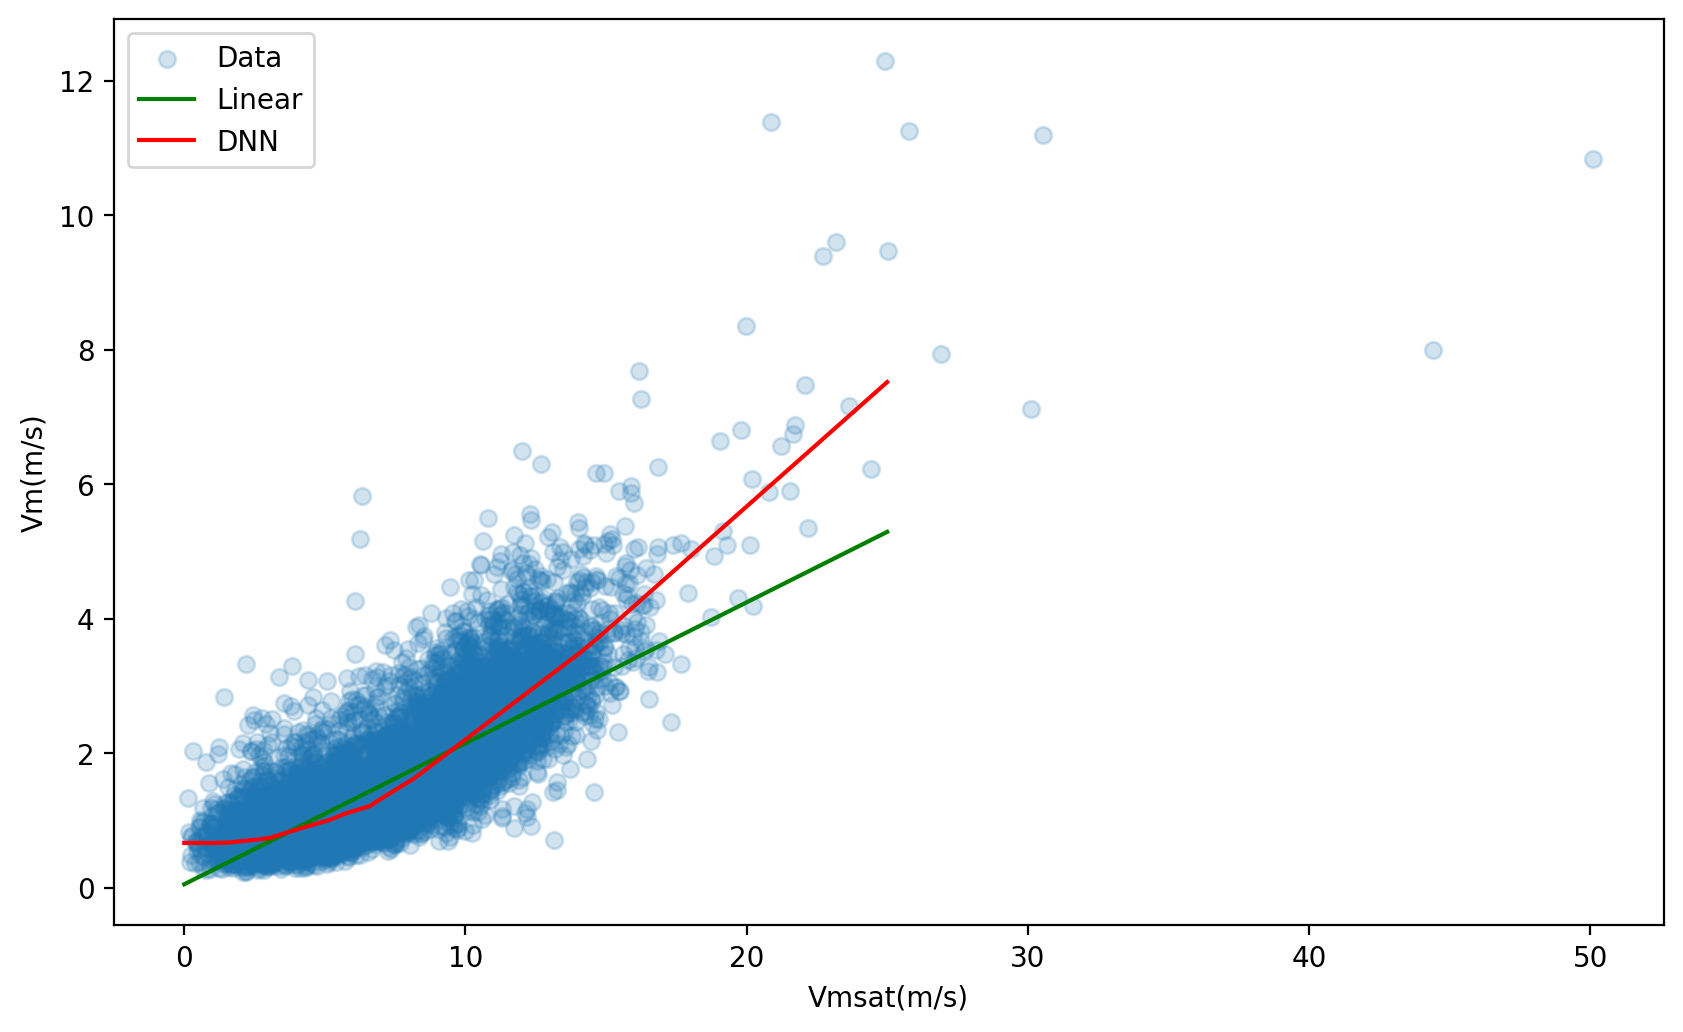

In [58]:
plt.figure(figsize=(10,6),dpi=200)
x = tf.linspace(0.0, 25, 251)
#y1 = dnn_model.predict(x)
y2 = dnn_Vmsat_model.predict(pd.DataFrame(x))
y4 = Vmsat_model.predict(pd.DataFrame(x))

plt.scatter(train_features['Vmsat'], train_labels, label='Data',alpha=0.2)
#plt.plot(x, y1, color='b', label='DNN_multi')
#plt.plot(x, x, color='k')
plt.plot(x, y4, color='g', label='Linear')
plt.plot(x, y2, color='r', label='DNN')
plt.xlabel('Vmsat(m/s)')
plt.ylabel('Vm(m/s)')
plt.legend()

In [59]:
linear_model.save('saved_model/Vmsat_H_linear_model')
Vmsat_model.save(    'saved_model/Vmsat_H_Vm_model')
dnn_model.save(   'saved_model/Vmsat_H_ddn_model')
dnn_Vmsat_model.save('saved_model/Vmsat_H_ddn_Vm_model')

INFO:tensorflow:Assets written to: saved_model/Vmsat_H_linear_model/assets
INFO:tensorflow:Assets written to: saved_model/Vmsat_H_Vm_model/assets
INFO:tensorflow:Assets written to: saved_model/Vmsat_H_ddn_model/assets
INFO:tensorflow:Assets written to: saved_model/Vmsat_H_ddn_Vm_model/assets
